## Image detection using YOLO algorithm or some variation or R-CNN

I'm going to attempt to implement some variation of the YOLO (You only look once) or R-CNN algorithm to detect polyps on colonoscopy footage. I'm working with pretty limited processing power so we will be using less computations than normal. (Hopfully using tf2)

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [14]:

from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2
import sys
sys.path.insert(0, '/Users/McClain/desktop/polyp_vis/keras-yolo2-master')
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline
tf.__version__

'2.0.0-alpha0'

In [3]:
LABELS = ['RBC']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [4]:
wt_path = 'yolo.weights'

In [5]:

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}


In [6]:

image_path = 'Labeled_original_yolo/yolo_original-PascalVOC-export/JPEGImages/'
annot_path = 'Labeled_original_yolo/yolo_original-PascalVOC-export/Annotations/'

all_imgs, seen_labels = parse_annotation(annot_path, image_path)

# add extensions to image name
for img in all_imgs:
    img['filename'] = img['filename']

In [7]:
batches = BatchGenerator(all_imgs, generator_config)

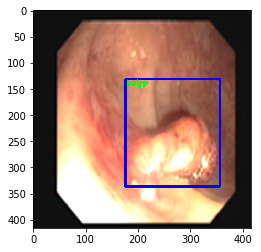

In [8]:
image = batches[0][0][0][0]
plt.imshow(image.astype('uint8'));

In [9]:
def normalize(image):
    return image/255.

In [10]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [78]:
#build the model for the pretrained weights

from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Lambda, Reshape

#input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
#true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
print(GRID_H, GRID_W, BOX, CLASS)

model = Sequential([
    #layer 1
    Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False, input_shape = (IMAGE_H, IMAGE_W, 3) ),
    BatchNormalization(name='norm_1'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(),
    
    # Layer 2
    Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False),
    BatchNormalization(name='norm_2'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3
    Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False),
    BatchNormalization(name='norm_3'),
    LeakyReLU(alpha=0.1),

    #layer 4
    Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False),
    BatchNormalization(name='norm_4'),
    LeakyReLU(alpha=0.1),

    #layer 5
    Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False),
    BatchNormalization(name='norm_5'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    #layer 6
    Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False),
    BatchNormalization(name='norm_6'),
    LeakyReLU(alpha=0.1),

    #layer 7
    Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False),
    BatchNormalization(name='norm_7'),
    LeakyReLU(alpha=0.1),

    #layer 8
    Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False, input_shape=(416,416,3)),
    BatchNormalization(name='norm_8'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    #layer 9
    Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False),
    BatchNormalization(name='norm_9'),
    LeakyReLU(alpha=0.1),

    #layer 10
    Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False),
    BatchNormalization(name='norm_10'),
    LeakyReLU(alpha=0.1),

    #layer 11
    Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False),
    BatchNormalization(name='norm_11'),
    LeakyReLU(alpha=0.1),

    #layyer 12
    Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False),
    BatchNormalization(name='norm_12'),
    LeakyReLU(alpha=0.1),

    #layer 13
    Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False),
    BatchNormalization(name='norm_13'),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),

    #layer 14
    Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False),
    BatchNormalization(name='norm_14'),
    LeakyReLU(alpha=0.1),

    #layer 15
    Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False),
    BatchNormalization(name='norm_15'),
    LeakyReLU(alpha=0.1),

    #layer 16
    Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False),
    BatchNormalization(name='norm_16'),
    LeakyReLU(alpha=0.1),

    #layer 17
    Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False),
    BatchNormalization(name='norm_17'),
    LeakyReLU(alpha=0.1),

    #layer 18
    Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False),
    BatchNormalization(name='norm_18'),
    LeakyReLU(alpha=0.1),

    #layer 19
    Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False),
    BatchNormalization(name='norm_19'),
    LeakyReLU(alpha=0.1),

    #layer 20
    Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False),
    BatchNormalization(name='norm_20'),
    LeakyReLU(alpha=0.1),

    Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False),
    BatchNormalization(name='norm_21'),
    LeakyReLU(alpha=0.1),
    Lambda(space_to_depth_x2),



    #layer 22
    Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False),
    BatchNormalization(name='norm_22'),
    LeakyReLU(alpha=0.1),

    #layer 23
    Conv2D(30, (1,1), strides=(1,1), padding='same', name='conv_23'),
    Reshape((13, 13, 5, 6))
])
model.compile()
model.summary()

13 13 5 1


AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [19]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Lambda, Reshape, InputLayer, MaxPooling2D

model2 = Sequential([    
    #layer 1
    Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False, input_shape=(IMAGE_H, IMAGE_W, 3), activation = ),
    BatchNormalization(name='norm_1'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(),
    ])

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

## Building Training and Testing Sets

photos and annotations are aready made i just want to sort them into folders here

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04),
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

train_data = tf.ones(shape=(1, 28, 28, 1))
test_data = tf.ones(shape=(1, 28, 28, 1))

In [4]:
import os, os.path
DIR = 'Labeled_original_yolo/yolo_original-PascalVOC-export/ImageSets/Main/'
[name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]

[]

In [11]:
DIR1 = 'Labeled_original_yolo/yolo_original-PascalVOC-export/ImageSets/Main/polyp_train.txt'
DIR2 = 'Labeled_original_yolo/yolo_original-PascalVOC-export/ImageSets/Main/polyp_val.txt'

d1= pd.read_csv(DIR1, sep = '\n')
d2= pd.read_csv(DIR2, sep = '\n')

train_photos = pd.DataFrame(data=d1)
val_photos = pd.DataFrame(data=d2)
type(train_photos)

pandas.core.frame.DataFrame